In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [2]:
%run create-blocks.ipynb # data will be in prioritized_blocks
pp.pprint(prioritized_blocks) # take a look
pp.pprint(token_to_block_dict) # and another look
print(token_array, len(token_array)) # and one more look

[ Block(token_count=2, start_position=4, end_position=6, all_start_positions=[2, 9, 18], witnesses={0, 1, 2}, witness_count=3, frequency=3),
  Block(token_count=2, start_position=18, end_position=20, all_start_positions=[3, 7, 14], witnesses={0, 1, 2}, witness_count=3, frequency=3),
  Block(token_count=1, start_position=7, end_position=9, all_start_positions=[4, 8, 15], witnesses={0, 1, 2}, witness_count=3, frequency=3),
  Block(token_count=1, start_position=11, end_position=13, all_start_positions=[5, 12, 23], witnesses={0, 1, 2}, witness_count=3, frequency=3),
  Block(token_count=1, start_position=15, end_position=17, all_start_positions=[1, 11, 17], witnesses={0, 1, 2}, witness_count=3, frequency=3),
  Block(token_count=3, start_position=15, end_position=16, all_start_positions=[1, 17], witnesses={0, 2}, witness_count=2, frequency=2),
  Block(token_count=3, start_position=18, end_position=19, all_start_positions=[7, 14], witnesses={1, 2}, witness_count=2, frequency=2),
  Block(token

# (THIS IS NO LONGER TRUE) Desired multi-skiplist

1. Keys are offsets in witnesses (up to one key for each and every witness)
1. Values are variant-graph nodes

Some variant graph nodes do not have values for all witnesses. If witness is not in current node,
can go to different node (on same or different level). 

In [3]:
#
# This file is part of Bluepass. Bluepass is Copyright (c) 2012-2014
# Geert Jansen.
#
# Bluepass is free software available under the GNU General Public License,
# version 3. See the file LICENSE distributed with this file for the exact
# licensing terms.

from __future__ import absolute_import, print_function

import os
import sys
import math
import random

__all__ = ['SkipList']


# The following functions are debugging functions. They are available only when
# Python is not started with -O.

if __debug__:

    def fmtnode(node):
        """Format a single skiplist node."""
        level = max(1, len(node) - 3)
        skip = '(none)' if level == 1 else node[-1]
        return '<Node(level={}, key={}, value={}, skip={})>' \
                    .format(level, node[0], node[1], skip)

    def dump(sl, file=sys.stdout):
        """Dump a skiplist to standard output."""
        print('== Dumping skiplist {0!r}'.format(sl), file=file)
        print('Level: {}/{}'.format(sl.level, sl.maxlevel), file=file)
        print('Size: {}'.format(len(sl)), file=file)
        node = sl._head
        print('{0} (head)'.format(fmtnode(node)), file=file)
        node = node[2]
        avglvl = avglen = avgsiz = 0
        while node is not sl._tail:
            print('{0}'.format(fmtnode(node)), file=file)
            node = node[2]
            avglvl += max(1, len(node) - 3)
            avglen += len(node)
            avgsiz += nodesize(node)
        print('{0} (tail)'.format(fmtnode(node)), file=file)
        print('Avg level: {:.2f}'.format(avglvl/len(sl)), file=file)
        print('Avg node len: {:.2f}'.format(avglen/len(sl)), file=file)
        print('Avg node memory: {:.2f}'.format(avgsiz/len(sl)), file=file)
        print(file=file)

    def check(sl):
        """Check the internal structure of a skiplist."""
        level = sl.maxlevel
        assert level > 0
        while sl._head[1+level] is sl._tail and level > 1:
            level -= 1
        assert level == sl.level
        assert sl._head[0] is sl._head[1] is None
        assert sl._head[-1] == 0
        pos = 0
        node = sl._head
        inbound = {id(sl._head): 0, id(sl._tail): len(sl)}
        while node is not sl._tail:
            assert isinstance(node, list)
            level = min(sl.level, max(1, len(node)-3))
            assert 1 <= level <= sl.maxlevel
            for i in range(1, level):
                fnode = node[2+i]
                flevel = min(sl.level, max(1, len(fnode)-3))
                if i == flevel-1:
                    inbound[id(fnode)] = pos
            if level > 1:
                assert id(node) in inbound
                assert pos == inbound[id(node)] + node[-1]
            for i in range(level):
                fnode = node[2+i]
                assert isinstance(fnode, list)
                level = max(1, len(node) - 3)
                assert level >= i+1
            node = node[2]
            pos += 1
        assert sl._tail[0] is None
        assert sl._tail[1] is None
        for i in range(sl.maxlevel):
            assert sl._tail[2+i] is None
        assert len(sl) == inbound[id(sl._tail)] + node[-1]

    def nodesize(node):
        """Return the size of a skiplist node."""
        size = sys.getsizeof(node)
        size += sys.getsizeof(node[0])
        size += sys.getsizeof(node[1])
        # All elements in [3:-1] are references so don't count
        if len(node) > 3:
            size += sys.getsizeof(node[-1])
        return size

    def getsize(sl):
        """Return total size of a skiplist."""
        size = sys.getsizeof(sl)
        size += sys.getsizeof(sl._level)
        node = sl._head
        while node is not sl._tail:
            size += nodesize(node)
            node = node[2]
        size += nodesize(node)
        size += sys.getsizeof(sl._path)  # contains references or None
        size += sys.getsizeof(sl._distance)
        for el in sl._distance:
            size += sys.getsizeof(el)
        return size


class SkipList(object):
    """An indexable skip list.

    A SkipList provides an ordered sequence of key-value pairs. The list is
    always sorted on key and supports O(1) forward iteration. It has O(log N)
    time complexity for key lookup, pair insertion and pair removal anywhere in
    the list. The list also supports O(log N) element access by position.

    The keys of all pairs you add to the skiplist must be be comparable against
    each other, and define the ``<`` and ``<=`` operators.
    """

    UNSET = object()

    p = int((1<<31) / math.e)
    maxlevel = 20

    # Kudos to http://pythonsweetness.tumblr.com/post/45227295342 for some
    # useful tricks, including using a list for the nodes to save memory.

    # Use the built-in Mersenne Twister random number generator. It is more
    # appropriate than SystemRandom because we don't need cryptographically
    # secure random numbers, and we don't want to do a system call to read
    # /dev/urandom for each random number we need (every insertion needs a new
    # random number).

    _rnd = random.Random()
    _rnd.seed(os.urandom(16))

    __slots__ = ('_level', '_head', '_tail', '_path', '_distance', '_last_comparable_node_higher')

#####
# Add _last-comparable_node property in __init__(); needed for floor() and 
# ceiling() (add to __slots__, too)
#####
    def __init__(self):
        self._level = 1
        self._head = self._new_node(self.maxlevel, None, None)
        self._tail = self._new_node(self.maxlevel, None, None)
        for i in range(self.maxlevel):
            self._head[2+i] = self._tail
        self._path = [None] * self.maxlevel
        self._distance = [None] * self.maxlevel

    def _new_node(self, level, key, value):
        # Node layout: [key, value, next*LEVEL, skip?]
        # The "skip" element indicates how many nodes are skipped by the
        # highest level incoming link.
        if level == 1:
            return [key, value, None]
        else:
            return [key, value] + [None]*level + [0]

    def _random_level(self):
        # Exponential distribution as per Pugh's paper.
        l = 1
        maxlevel = min(self.maxlevel, self.level+1)
        while l < maxlevel and self._rnd.getrandbits(31) < self.p:
            l += 1
        return l

    def _create_node(self, key, value):
        # Create a new node, updating the list level if required.
        level = self._random_level()
        if level > self.level:
            self._tail[-1] = len(self)
            self._level = level
            self._path[level-1] = self._head
            self._distance[level-1] = 0
        return self._new_node(level, key, value)

    def _find_lt(self, key):
        # Find path to last node < key
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
#####
# Keys are partially ordered, so if two are not comparable (because they
# share no sigla), the comparator in S_Key will raise a ComparisonError,
# which we'll trap and then skip to the next key)
#
# We add and use last_comparable_node for our floor() and ceiling(), so
# that we don't return a node that is unordered with respect to the one we
# are querying
#
# Same modification in _find_lt() and _find_lte()
#####
            nnode = node[2+i]
#             while nnode is not self._tail and nnode[0] < key:
#                 nnode, node = nnode[2+i], nnode
#                 distance += 1 if i == 0 else node[-1]
            while nnode is not self._tail:
                try:
                    if nnode[0] < key:
                        nnode, node = nnode[2+i], nnode
                        distance += 1 if i == 0 else node[-1]
                        last_comparable_node = node
                    else:
                        break
                except ComparisonError:
                    nnode = nnode[2+i]
                    continue
            self._path[i] = node
            self._distance[i] = distance
        self._last_comparable_node_higher = nnode


    def _find_lte(self, key):
        # Find path to last node <= key
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
            nnode = node[2+i]
#             while nnode is not self._tail and nnode[0] <= key:
#                 nnode, node = nnode[2+i], nnode
#                 distance += 1 if i == 0 else node[-1]
            while nnode is not self._tail:
                try:
                    if nnode[0] <= key:
                        nnode, node = nnode[2+i], nnode
                        distance += 1 if i == 0 else node[-1]
                        last_comparable_node = node
                    else:
                        break
                except ComparisonError:
                    nnode = nnode[2+i]
                    continue
            self._path[i] = node
            self._distance[i] = distance
        self._last_comparable_node_higher = nnode

    def _find_pos(self, pos):
        # Create path to node at pos.
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
            nnode = node[2+i]
            ndistance = distance + (1 if i == 0 else nnode[-1])
            while nnode is not self._tail and ndistance <= pos:
                nnode, node, distance = nnode[2+i], nnode, ndistance
                ndistance += 1 if i == 0 else nnode[-1]
            self._path[i] = node
            self._distance[i] = distance

    def _insert(self, node):
        # Insert a node in the list. The _path and _distance must be set.
        path, distance = self._path, self._distance
        # Update pointers
        level = max(1, len(node) - 3)
        for i in range(level):
            node[2+i] = path[i][2+i]
            path[i][2+i] = node
        if level > 1:
            node[-1] = 1 + distance[0] - distance[level-1]
        # Update skip counts
        node = node[2]
        i = 2; j = min(len(node) - 3, self.level)
        while i <= self.level:
            while j < i:
                node = node[i]
                j = min(len(node) - 3, self.level)
            node[-1] -= distance[0] - distance[j-1] if j <= level else -1
            i = j+1

    def _remove(self, node):
        # Remove a node. The _path and _distance must be set.
        path, distance = self._path, self._distance
        level = max(1, len(node) - 3)
        for i in range(level):
            path[i][2+i] = node[2+i]
        # Update skip counts
        value = node[1]
        node = node[2]
        i = 2; j = min(len(node) - 3, self.level)
        while i <= self.level:
            while j < i:
                node = node[i]
                j = min(len(node) - 3, self.level)
            node[-1] += distance[0] - distance[j-1] if j <= level else -1
            i = j+1
        # Reduce level if last node on current level was removed
        while self.level > 1 and self._head[1+self.level] is self._tail:
            self._level -= 1
            self._tail[-1] += self._tail[-1] - len(self)
        return value

    # PUBLIC API ...

    @property
    def level(self):
        """The current level of the skip list."""
        return self._level

    def insert(self, key, value):
        """Insert a key-value pair in the list.

        The pair is inserted at the correct location so that the list remains
        sorted on *key*. If a pair with the same key is already in the list,
        then the pair is appended after all other pairs with that key.
        """
        self._find_lte(key)
        node = self._create_node(key, value)
        self._insert(node)

    def replace(self, key, value):
        """Replace the value of the first key-value pair with key *key*.

        If the key was not found, the pair is inserted.
        """
        self._find_lt(key)
        node = self._last_comparable_node_higher
        if node is self._tail or key < node[0]:
            node = self._create_node(key, value)
            self._insert(node)
        else:
            node[1] = value

    def clear(self):
        """Remove all key-value pairs."""
        for i in range(self.maxlevel):
            self._head[2+i] = self._tail
            self._tail[-1] = 0
        self._level = 1

    def __len__(self):
        """Return the number of pairs in the list."""
        dist = 0
        idx = self.level + 1
        node = self._head[idx]
        while node is not self._tail:
            dist += node[-1] if idx > 2 else 1
            node = node[idx]
        dist += node[-1]
        return dist

    __bool__ = __nonzero__ = lambda self: len(self) > 0

    def __repr__(self):
        return type(self).__name__ + '((' + repr(list(self.items()))[1:-1] + '))'

    def items(self, start=None, stop=None):
        """Return an iterator yielding pairs.

        If *start* is specified, iteration starts at the first pair with a key
        that is larger than or equal to *start*. If not specified, iteration
        starts at the first pair in the list.

        If *stop* is specified, iteration stops at the last pair that is
        smaller than *stop*. If not specified, iteration end with the last pair
        in the list.
        """
        if start is None:
            node = self._head[2]
        else:
            self._find_lt(start)
            node = self._last_comparable_node_higher
        while node is not self._tail and (stop is None or node[0] < stop):
            yield (node[0], node[1])
            node = node[2]

    __iter__ = items

    def keys(self, start=None, stop=None):
        """Like :meth:`items` but returns only the keys."""
        return (item[0] for item in self.items(start, stop))

    def values(self, start=None, stop=None):
        """Like :meth:`items` but returns only the values."""
        return (item[1] for item in self.items(start, stop))

    def popitem(self):
        """Removes the first key-value pair and return it.

        This method raises a ``KeyError`` if the list is empty.
        """
        node = self._head[2]
        if node is self._tail:
            raise KeyError('list is empty')
        self._find_lt(node[0])
        self._remove(node)
        return (node[0], node[1])

    # BY KEY API ...

    def search(self, key, default=None):
        """Find the first key-value pair with key *key* and return its value.

        If the key was not found, return *default*. If no default was provided,
        return ``None``. This method never raises a ``KeyError``.
        """
        self._find_lt(key)
        node = self._last_comparable_node_higher
        if node is self._tail or key < node[0]:
            return default
        return node[1]

    def remove(self, key):
        """Remove the first key-value pair with key *key*.

        If the key was not found, a ``KeyError`` is raised.
        """
        self._find_lt(key)
        node = self._last_comparable_node_higher
        if node is self._tail or key < node[0]:
            raise KeyError('{!r} is not in list'.format(key))
        self._remove(node)

    def pop(self, key, default=UNSET):
        """Remove the first key-value pair with key *key*.

        If a pair was removed, return its value. Otherwise if *default* was
        provided, return *default*. Otherwise a ``KeyError`` is raised.
        """
        self._find_lt(key)
        node = self._last_comparable_node_higher
        if node is self._tail or key < node[0]:
            if default is self.UNSET:
                raise KeyError('key {!r} not in list')
            return default
        self._remove(node)
        return node[1]

    def __contains__(self, key):
        """Return whether *key* is contained in the list."""
        self._find_lt(key)
        node = self._last_comparable_node_higher
        return node is not self._tail and not key < node[0]

    def index(self, key, default=UNSET):
        """Find the first key-value pair with key *key* and return its position.

        If the key is not found, return *default*. If default was not provided,
        raise a ``KeyError``
        """
        self._find_lt(key)
        node = self._last_comparable_node_higher
        if node is self._tail or key < node[0]:
            if default is self.UNSET:
                raise KeyError('key {!r} not in list'.format(key))
            return default
        return self._distance[0]

    def count(self, key):
        """Return the number of pairs with key *key*."""
        count = 0
        pos = self.index(key, -1)
        if pos == -1:
            return count
        count += 1
        for i in range(pos+1, len(self)):
            if self[i][0] != key:
                break
            count += 1
        return count

    # BY POSITION API ...

    def __getitem__(self, pos):
        """Return a pair by its position.

        If *pos* is a slice, then return a generator that yields pairs as
        specified by the slice.
        """
        size = len(self)
        if isinstance(pos, int):
            if pos < 0:
                pos += size
            if not 0 <= pos < size:
                raise IndexError('list index out of range')
            self._find_pos(pos)
            node = self._path[0][2]
            return (node[0], node[1])
        elif isinstance(pos, slice):
            start, stop = pos.start, pos.stop
            if start is None:
                start = 0
            elif start < 0:
                start += size
            if stop is None:
                stop = size
            elif stop < 0:
                stop += size
            self._find_pos(start)
            def genpairs():
                pos = start; node = self._path[0][2]
                while node is not self._tail and pos < stop:
                    yield (node[0], node[1])
                    node = node[2]; pos += 1
            return genpairs()
        else:
            raise TypeError('expecting int or slice, got {0.__name__!r}'.format(type(pos)))

    def __delitem__(self, pos):
        """Delete a pair by its position."""
        if not isinstance(pos, int):
            raise TypeError('expecting int, got {0.__name__!r}'.format(type(pos)))
        size = len(self)
        if pos < 0:
            pos += size
        if not 0 <= pos < size:
            raise IndexError('list index out of range')
        self._find_pos(pos)
        node = self._path[0][2]
        self._remove(node)

    def __setitem__(self, pos, value):
        """Set a value by its position."""
        if not isinstance(pos, int):
            raise TypeError('expecting int, got {0.__name__!r}'.format(type(pos)))
        size = len(self)
        if pos < 0:
            pos += size
        if not 0 <= pos < size:
            raise IndexError('list index out of range')
        self._find_pos(pos)
        node = self._path[0][2]
        node[1] = value

In [4]:
from dataclasses import dataclass

@dataclass
class SkiplistNode:
    """Declare SkipListNode class for export in dumpNodes()"""
    level: int
    key: str
    value: list
    name: str = None

def getSkiplistNodeData(node):
    level = max(1, len(node) - 3)
    key = node[0]
    value = [node[1]][0]
    return(level, key, value)

def dumpNodes(sl):
    SkiplistNodes = []
    node = sl._head
    nodeValues = getSkiplistNodeData(node)
    SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2], name="head"))
    node = node[2]
    while node is not sl._tail:
        nodeValues = getSkiplistNodeData(node)
        SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2]))
        node = node[2]
    nodeValues = getSkiplistNodeData(node)
    SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2], name="tail"))
    return SkiplistNodes

def floor(sl: SkipList, key: str) -> str:
    """Return highest key value that is less than the new key that we seek to place

    Assumption: keys are unique
    Note: lt, not le (unlike Java)"""
    sl._find_lte(key) # change state (eek!)
    return sl._path[0][0] if sl._path[0] else None

def ceiling(sl: SkipList, key: str) -> str:
    """Return lowest value that is greater than the new key that we seek to place

    Assumption: keys are unique
    Note: gt, not ge (unlike Java)"""

    sl._find_lte(key) # change state (eek!)
    return sl._last_comparable_node_higher[0] if sl._last_comparable_node_higher else None

In [5]:
from functools import total_ordering

# Find all witness that are present on both items (ignore those on only one item)
#     If none, raise an error
#     If some, compare in arbitrary but consistent order
#         If first pair differs, return result
#         If first pair matches, check next pair

class ComparisonError(Exception):
    def __init__(self, message):
        self.message = message
    def __str__(self):
        return self.message

@total_ordering
class VG_node:
    """Variant graph node, used as key in skiplist

    We don't care about the value in the skiplist; the node contains all information"""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__(self):
        return "|".join([":".join([str(key), str(getattr(self, key))]) for key in self.sigla()])
    def __setitem__(self, key, value):
        self.__dict__[key] = value
    def __getitem__(self, key):
        return self.__dict__[key]
    def __contains__(self, key):
        return key in self.__dict__
    def sigla(self):
        return self.__dict__.keys()
    def find_shared_sigla(self, other):
        """Return shared sigla for use in comparison, raise error if none"""
        shared_sigla = sorted(set(self.sigla()).intersection(set(other.sigla())))
        if not shared_sigla:
            raise ComparisonError("No shared sigla; cannot be compared")
        return shared_sigla
    def __eq__(self, other):
        shared_sigla = self.find_shared_sigla(other)
        return [getattr(self, siglum) for siglum in shared_sigla] == [getattr(other, siglum) for siglum in shared_sigla]
    def __lt__(self, other):
        shared_sigla = self.find_shared_sigla(other)
#         print("We are comparing the following sigla: "+str(shared_sigla))
#         print(str(self) + " : " + str(other))
        return [getattr(self, siglum) for siglum in shared_sigla] < [getattr(other, siglum) for siglum in shared_sigla]

# Skiplist setup code above, now create vg (variant graph) skiplist below

In [6]:
vg = SkipList()
tail_value = len(token_array) + 1
vg.insert(VG_node(w0=-1, w1=-1, w2=-1), ['[head]'])
vg.insert(VG_node(w0=tail_value, w1=tail_value, w2=tail_value), ['[tail]'])
# To update a VG node, try modifying it in place (i.e., modify the skiplist key in place)
# If that breaks, remove it, update it, and reinsert it (verify remove() code, since we modified insert())
dumpNodes(vg)
for index, prioritized_block in enumerate(prioritized_blocks):
    # add each token from the block individually
    # first block: Block(token_count=2, start_position=4, end_position=6, all_start_positions=[2, 9, 18], witnesses={0, 1, 2}, witness_count=3, frequency=3)
    if index: # limit number of blocks for testing; open the limit for production
        for start_position in prioritized_block.all_start_positions:
            witness_token_positions = range(start_position, start_position + prioritized_block.token_count)
            current_witness = 'w' + str(token_membership_array[start_position])
            for witness_token_pos in witness_token_positions:
                # get all tokens for each witness and retrieve token string and witness identifier
                # current_token = token_array[witness_token_pos] # sanity check
                # print(current_token, current_witness) # sanity check
                # https://stackoverflow.com/questions/42845252/python-how-to-pass-argument-name-using-variable
                key_to_check = VG_node(**{current_witness: witness_token_pos})
                # print('we are checking ' + str(key_to_check))
                if key_to_check not in vg:
                    # print('we need to add  ', str(key_to_check))
                    floor_node = floor(vg, key_to_check)
                    # print('floor =         ', floor_node)
                    post_floor_index = vg.index(floor_node) + 1
                    # print('post_floor index =   ', post_floor_index)
                    ceiling_node = ceiling(vg, key_to_check)
                    # print('ceiling =       ', ceiling_node)
                    ceiling_index = vg.index(ceiling_node)
                    # print('ceiling index = ', ceiling_index)
                    # NB: slicing returns tuple (vg_node, [offsets])
                    current_slice = list(vg[post_floor_index : ceiling_index])
                    if not len(current_slice): # floor and ceiling are adjacent, so insert between them
                        # insertion position is automatic for a skiplist (if the comparator is doing its job)
                        vg.insert(key_to_check, [witness_token_pos])
                    else: # do stuff
                        print()
                        # #####
                        # Are any of the slice nodes candidates for placing new token?
                        # Blocks contain information about all occurrences of pattern.
                        # If token is part of the same block, it can be added to it?
                        #
                        # We already did string matching when we constructed blocks. Now
                        # find intersection of:
                        #   1) nodes between floor and ceiling and
                        #   2) instances of block
                        # If there is an intersection, that's the node with which to align.
                        # To do that:
                        #   1) Remove the existing node
                        #   2) Modify its key (and value?) and insert it
                        # We think it will go back into the same place, but if not, the
                        # skiplist should place it correctly (topologically) anyway.
                        # NB: We do not modify the key or value in place!
                        #
                        # Possibilities:
                        #   1) none
                        #      Insert new node
                        #   2) exactly one
                        #      Add to it
                        #   3) more than one (if there is repetition)
                        #      Defer consideration until we encounter one
                        #
                        # print(f"{slice_length=}") # diagnostic
                        #
                        # Is it situation 1, 2, or 3?
                        #
                        # token_to_block_dict is a multi-valued dictionary:
                        #   keys are token offsets
                        #   values are lists of block offsets in  prioritized_blocks list, which serve as block ids
                        for current_node in current_slice: # look at all vg nodes between floor and ceiling; tuple of vg_node, [offsets]
                            print("We are visiting "+str(current_node)+" as a potential candidate for alignment")
                            # index is for block we're trying to place; is in graph between floor and ceiling?
                            blocks_for_vg_node = [] # blocks associated with current variant graph node
                            for current_token_offset in current_node[1]: # for each node, look at each of its values
                                blocks_for_current_token = token_to_block_dict[current_token_offset] # non-empty list of integers
                                blocks_for_vg_node.extend(blocks_for_current_token) # list may include duplicates; do we care?
                            print(f"{blocks_for_vg_node=}")
                            if index in blocks_for_vg_node: # does the current block, inside the slice, contain the node we care about?
                                new_key_siglum = 'w' + str(token_membership_array[witness_token_pos]) # witness siglum for new token instance
                                new_key = current_node[0] # start building new key from old key
                                if new_key_siglum in new_key:
                                    raise Exception("The key is already on this node")
                                new_key[new_key_siglum] = witness_token_pos # add new token to key
                                new_value = current_node[1]
                                new_value.append(witness_token_pos) # add new token to value, too
                                print(new_key, new_value)
                                vg.remove(current_node[0]) # found one; remove matching node by key
                                vg.insert(new_key, new_value) # update key and value, insert
                                break
                        else:
                            vg.insert(key_to_check, [witness_token_pos]) # didn't find one, insert new

# place tokens that are not parts of blocks
unplaced_tokens = [offset for offset in range(len(token_array) - 1) 
                   if offset not in token_to_block_dict 
                   and isinstance(token_membership_array[offset], int)]
for unplaced_token in unplaced_tokens:
    new_node = VG_node(**{'w' + str(
token_membership_array[unplaced_token]): unplaced_token})
    vg.insert(new_node, [unplaced_token])

dumpNodes(vg)
pp.pprint(prioritized_blocks)

# Resume here
# Add token offset to list of values, don't create new list
# Need to compare candidate nodes (blocks contain explicit numbers only for first node of block token sequence)
# If there is no repetition before floor and ceiling:
# 1) No candidate matches, so create new onode
# 2) One candidate matches, so remove key, add new information, and insert modified node
# 3) More than one candidate matches (repetition) — we don't yet know what to do

[SkiplistNode(level=20, key=None, value=None, name='head'),
 SkiplistNode(level=1, key=w0:-1|w1:-1|w2:-1, value=['[head]'], name=None),
 SkiplistNode(level=1, key=w0:25|w1:25|w2:25, value=['[tail]'], name=None),
 SkiplistNode(level=20, key=None, value=None, name='tail')]


We are visiting (w0:3, [3]) as a potential candidate for alignment
blocks_for_vg_node=[0, 1, 5, 10]
w0:3|w1:7 [3, 7]

We are visiting (w0:4, [4]) as a potential candidate for alignment
blocks_for_vg_node=[1, 2]
w0:4|w1:8 [4, 8]

We are visiting (w0:3|w1:7, [3, 7]) as a potential candidate for alignment
blocks_for_vg_node=[0, 1, 5, 10, 1, 6, 10]
w0:3|w1:7|w2:14 [3, 7, 14]

We are visiting (w0:4|w1:8, [4, 8]) as a potential candidate for alignment
blocks_for_vg_node=[1, 2, 1, 2, 6, 7]
w0:4|w1:8|w2:15 [4, 8, 15]

We are visiting (w0:5, [5]) as a potential candidate for alignment
blocks_for_vg_node=[3]
w0:5|w1:12 [5, 12]

We are visiting (w0:5|w1:12, [5, 12]) as a potential candidate for alignment
blocks_for_vg_node=[3, 3]
w0:5|w1:12|w2:23 [5, 12, 23]

We are visiting (w1:11, [11]) as a potential candidate for alignment
blocks_for_vg_node=[4, 8]
w1:11|w2:17 [11, 17]

We are visiting (w0:4|w1:8|w2:15, [4, 8, 15]) as a potential candidate for alignment
blocks_for_vg_node=[1, 2, 1, 2, 6, 7, 

Exception: The key is already on this node

# Visualization code below, assumes vg (variant graph) skiplist exists

In [7]:
# Dataclasses, variables, and functions for SVG visualization of skiplist
# Input parameters are in camelCase because Python doesn't allow hyphens in variable names

@dataclass
class SVGRect:
    x: int
    y: int
    height: int
    width: int
    stroke: str
    strokeWidth: int
    fill: str
    def __str__(self):
        return f'<rect x="{self.x}" y="{self.y}" height="{self.height}" width="{self.width}" stroke="{self.stroke}" stroke-width="{self.strokeWidth}" fill="{self.fill}"/>'

@dataclass
class SVGCircle:
    cx: int
    cy: int
    r: int
    fill: str
    def __str__(self):
        return f'<circle cx="{self.cx}" cy="{self.cy}" r="{self.r}" fill="{self.fill}"/>'

@dataclass
class SVGText:
    x: int
    y: int
    dominantBaseline: str
    textAnchor: str
    fill: str
    fontSize: str
    content: str
    dy: int = None
    def __str__(self):
        dyRep = f'dy="{self.dy}"' if self.dy else ''
        return f'<text x="{self.x}" y="{self.y}" {dyRep} dominant-baseline="{self.dominantBaseline}" text-anchor="{self.textAnchor}" fill="{self.fill}" font-size="{self.fontSize}">{self.content}</text>'

@dataclass
class SVGLine:
    x1: int
    y1: int
    x2: int
    y2: int
    stroke: str
    strokeWidth: int
    markerEnd: str
    def __str__(self):
        return f'<line x1="{self.x1}" y1="{self.y1}" x2="{self.x2}" y2="{self.y2}" stroke="{self.stroke}" stroke-width="{self.strokeWidth}" marker-end="{self.markerEnd}"/>'

def SVGStartTag(x:int, y:int, width:int, height:int) -> str:
    return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="{x} {y} {width} {height + 100}" height="{height + 100}">'

defs = '''
<defs>
  <marker id="arrowend"
          viewBox="-30 -8 30 16"
          markerWidth="30"
          markerHeight="8">
     <path d="M -30 0  L -30 8  L 0 0  L -30 -8  Z" fill="black"/>
 </marker>
</defs>
'''

In [8]:
# SVG constants
SkiplistNodes = dumpNodes(vg) # node 0 is head, data begins at node 1
boxSize = 100
boxSpacing = boxSize * 2
boxCenterOffset = boxSize / 2
textShift = 3 # @dy value to center text vertically in rectangle
textSize = '400%'
dataNodes = [x for x in SkiplistNodes if not x.name]
maxLevels = max(map(lambda x: x.level, dataNodes))
nodeCount = len(SkiplistNodes)
dataNodeCount = len(dataNodes)
circleRadius = boxSize * .1
nilColor = '#E8E8E8'

# test constants

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# SkiplistNodes
# boxSize
# boxSpacing
# boxCenterOffset
# textShift
# textSize
# dataNodes
# maxLevels
# nodeCount
# dataNodeCount
# circleRadius
# nilColor

In [9]:
from typing import List
def computeOffsetsOfNodesAtLevel(nodes:List[SkiplistNode], level:int) -> List:
    '''Filter to keep all nodes at specified level or higher

    Incorporate head and tail
    '''
    offsets = [0]
    for offset, node in enumerate(nodes):
        if node.level >= level and not node.name:
            offsets.append(offset)
    offsets.append(nodeCount - 1) # offset of tail
    return offsets

In [10]:
# construct SVG
SVGElements = []
# start tag
SVGElements.append(SVGStartTag(x=-boxSpacing, y=-(maxLevels + 1) * boxSize, width=boxSpacing *
                               (nodeCount + 5), height=(maxLevels + 2) * boxSize))
# arrowhead
SVGElements.append(defs)
# nodes
for offset, node in enumerate(SkiplistNodes):
    if node.name == 'head':
        for level in range(1, maxLevels + 1): # rectangles
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, width=boxSize,
                                       height=boxSize, stroke='black', strokeWidth=2, fill='none'))
            SVGElements.append(SVGCircle(cx=offset * boxSpacing + boxCenterOffset, cy=-level * boxSize + boxCenterOffset,
                                         r=circleRadius, fill='black'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150, dominantBaseline='middle',
                                   textAnchor='middle', fill='gray', fontSize=textSize, content='[head]'))
    elif node.name == 'tail':
        for level in range(1, maxLevels + 1): # rectangles
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, width=boxSize, \
                                       height=boxSize, stroke='black', strokeWidth=2, fill=nilColor))
            SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=-(level * boxSize) + boxCenterOffset, \
                                       dominantBaseline='middle', textAnchor='middle', fill='black', fontSize='300%', content='NIL'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150,  dominantBaseline='middle', \
                                   textAnchor='middle', fill='gray', fontSize=textSize, content='[tail]'))
    else: #regular node
        # create numbered yellow box for node, with value underneath
        SVGElements.append(SVGRect(x=offset * boxSpacing, y=0, height=boxSize, width=boxSize, stroke='black',
                                   strokeWidth=2, fill='yellow'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=boxCenterOffset, dy=textShift,
                                   dominantBaseline='middle', textAnchor='middle', fill='black', \
                                   fontSize=textSize, content=offset))
        string_value = token_array[node.value[0]] if isinstance(node.value[0], int) else node.value[0]
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150, textAnchor='middle', \
                                  dominantBaseline='middle', fill='black', fontSize=textSize, content=string_value))
        # show sigla under value
        sigla = [item.split(':')[0] for item in str(node.key).split('|')]
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=200, textAnchor='middle',
            dominantBaseline='middle', fill='black', fontSize='150%', content=sigla))
        # create dotted boxes for all levels
        for level in range(1, node.level + 1):
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, height=boxSize, width=boxSize, \
                                       stroke='black', strokeWidth=2, fill='none'))
            SVGElements.append(SVGCircle(cx=offset * boxSpacing + boxCenterOffset, cy=-level * boxSize + boxCenterOffset, \
                                         r=circleRadius, fill='black'))
# draw arrows for levels
for currentLevel in range(1, maxLevels + 1):
    offsetsOfNodesToLink = computeOffsetsOfNodesAtLevel(SkiplistNodes, currentLevel)
    for sourceOffset, targetOffset in zip(offsetsOfNodesToLink, offsetsOfNodesToLink[1:]):
        height = -(currentLevel) * boxSize + boxCenterOffset
        SVGElements.append(SVGLine(x1=sourceOffset * boxSpacing + boxCenterOffset, y1=height, \
                                   x2=targetOffset * boxSpacing, y2=height, \
                                   stroke='black', strokeWidth=2, markerEnd='url(#arrowend)'))
SVGElements.append('</svg>')

In [11]:
SVGstring = ("\n".join([str(x) for x in SVGElements]))
# SkiplistNodes
# print(SVGstring)

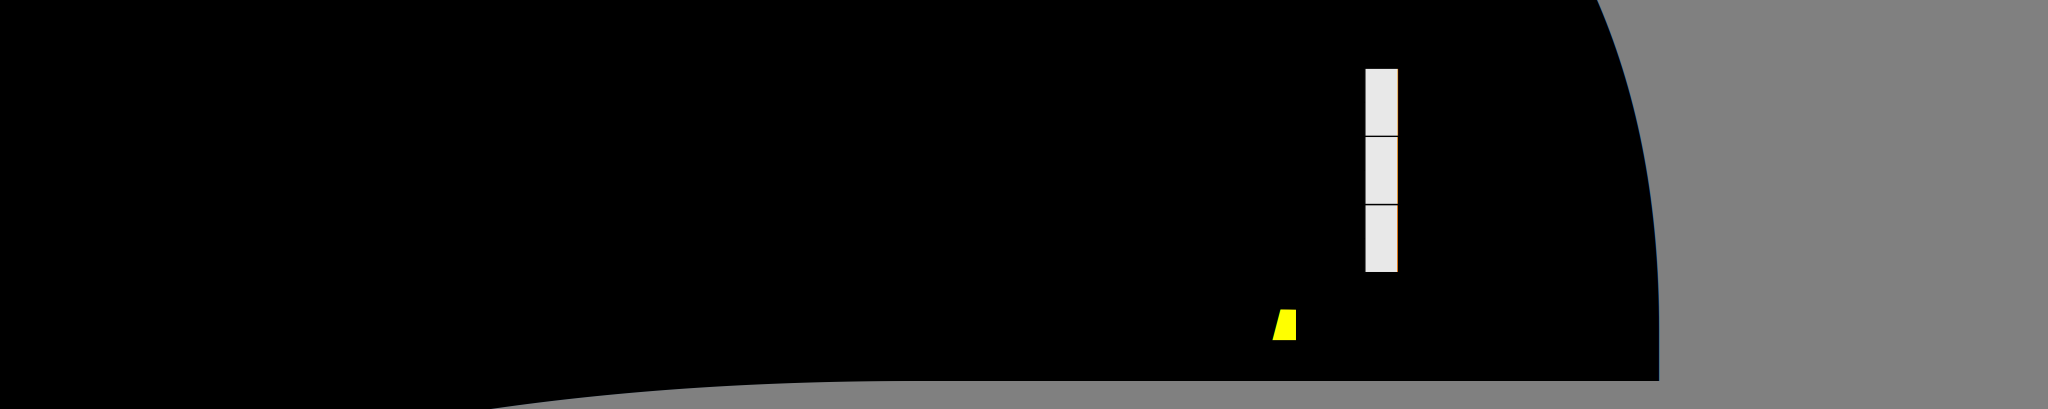

In [12]:
from IPython.display import SVG, display
display(SVG(SVGstring))

In [13]:
for index,node in enumerate(dumpNodes(vg)):
    pp.pprint((index,node))

(0, SkiplistNode(level=20, key=None, value=None, name='head'))
(1, SkiplistNode(level=1, key=w0:-1|w1:-1|w2:-1, value=['[head]'], name=None))
(2, SkiplistNode(level=2, key=w0:1, value=[1], name=None))
(3, SkiplistNode(level=1, key=w0:2, value=[2], name=None))
(4, SkiplistNode(level=2, key=w0:3|w1:7|w2:14, value=[3, 7, 14], name=None))
(5, SkiplistNode(level=1, key=w0:4|w1:8|w2:15, value=[4, 8, 15], name=None))
(6, SkiplistNode(level=1, key=w1:11|w2:17, value=[11, 17], name=None))
(7, SkiplistNode(level=3, key=w0:5|w1:12|w2:23, value=[5, 12, 23], name=None))
(8, SkiplistNode(level=1, key=w0:25|w1:25|w2:25, value=['[tail]'], name=None))
(9, SkiplistNode(level=20, key=None, value=None, name='tail'))


In [14]:
prioritized_blocks

[Block(token_count=2, start_position=4, end_position=6, all_start_positions=[2, 9, 18], witnesses={0, 1, 2}, witness_count=3, frequency=3),
 Block(token_count=2, start_position=18, end_position=20, all_start_positions=[3, 7, 14], witnesses={0, 1, 2}, witness_count=3, frequency=3),
 Block(token_count=1, start_position=7, end_position=9, all_start_positions=[4, 8, 15], witnesses={0, 1, 2}, witness_count=3, frequency=3),
 Block(token_count=1, start_position=11, end_position=13, all_start_positions=[5, 12, 23], witnesses={0, 1, 2}, witness_count=3, frequency=3),
 Block(token_count=1, start_position=15, end_position=17, all_start_positions=[1, 11, 17], witnesses={0, 1, 2}, witness_count=3, frequency=3),
 Block(token_count=3, start_position=15, end_position=16, all_start_positions=[1, 17], witnesses={0, 2}, witness_count=2, frequency=2),
 Block(token_count=3, start_position=18, end_position=19, all_start_positions=[7, 14], witnesses={1, 2}, witness_count=2, frequency=2),
 Block(token_count=2

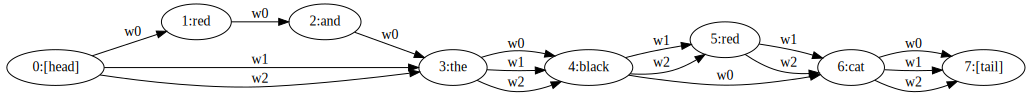

In [15]:
# get ready to visualize the decision tree in SVG
import graphviz
from IPython.display import SVG

# TODO: use tm instead of to_variant_graph_nodes because reasons
# TODO: add token offsets with witness identifiers to label

# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
a.attr(rankdir = "LR")
# #####
# new code starts here
# #####
for index, vg_node in enumerate(dumpNodes(vg)[1:-1]): # list of SkiplistNode objects, omit head and tail
# create nodes
    node_id = str(index)
    token_string = token_array[vg_node.value[0]] if isinstance(vg_node.value[0], int) else vg_node.value[0]
    a.node(node_id, label=(node_id + ':' + token_string))
# create edges witness by witness
# print([x.key.sigla() for x in dumpNodes(vg)[1:-1]]) # keys for all skiplist nodes are variant-graph nodes, which have a sigla() method

for w in range(len(witnesses)): # w is offset of witness in list of witnesses
    siglum = 'w' + str(w) # siglum as recorded in SkiplistNode keys
    # witness_nodes = filter(lambda x: siglum in x.key.sigla(), dumpNodes(vg)[1:-1]) # this loses the original position, which is the node id in the variant graph
    # print(list(witness_nodes)) take a look
    witness_nodes = []
    for index, vg_node in enumerate(dumpNodes(vg)[1:-1]):
        if siglum in vg_node.key.sigla():
            witness_nodes.append(index)
    for source, target in zip(witness_nodes, witness_nodes[1:]):
        a.edge(str(source), str(target), label=str(siglum))
SVG(a.view())

In [16]:
for index,value in enumerate(token_array):
    print((index, value))

(0, 'the')
(1, 'red')
(2, 'and')
(3, 'the')
(4, 'black')
(5, 'cat')
(6, ' #1 ')
(7, 'the')
(8, 'black')
(9, 'and')
(10, 'the')
(11, 'red')
(12, 'cat')
(13, ' #2 ')
(14, 'the')
(15, 'black')
(16, 'and')
(17, 'red')
(18, 'and')
(19, 'the')
(20, 'blue')
(21, 'and')
(22, 'green')
(23, 'cat')
